### FDS (Fraud Detection System, 이상금융거래탐지시스템)

##### Module import

In [1]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
import missingno as msno
import tensorflow as tf

from sklearn import metrics, preprocessing
from sklearn.preprocessing import Imputer, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics, preprocessing
from sklearn.decomposition import PCA
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

##### Reduce Memory Usage

In [2]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

Wall time: 0 ns


##### Load CSV file

In [3]:
train_tr = pd.read_csv('./input/train_transaction.csv', index_col='TransactionID')
print("Completed load")
train_id = pd.read_csv('./input/train_identity.csv', index_col='TransactionID')
print("Completed load")
test_tr = pd.read_csv('./input/test_transaction.csv', index_col='TransactionID')
print("Completed load")
test_id = pd.read_csv('./input/test_identity.csv', index_col='TransactionID')
print("Completed load")
sub = pd.read_csv('./input/sample_submission.csv', index_col='TransactionID')
print("Completed load")

Completed load
Completed load
Completed load
Completed load
Completed load


##### Left join by TransactionId

In [ ]:
train = pd.merge(train_tr, train_id,
                        how='left',
                        on='TransactionID')
del train_tr, train_id

test = pd.merge(test_tr, test_id,
                        how='left',
                        on='TransactionID')
del test_tr, test_id

train = reduce_mem_usage(train)
test  = reduce_mem_usage(test)

Memory usage of dataframe is 1955.37 MB
Memory usage after optimization is: 527.82 MB
Decreased by 73.0%
Memory usage of dataframe is 1673.87 MB


##### EDA(Exploratory Data Analysis)

##### Preprocessing missing values

In [19]:
"""
If the fraud column is true,
Column variables with a lower missing value
may affect the fraud variable.
"""

# frauddf = train[(train.isFraud == 1)]
#frauddf.isnull().mean(axis=0)
# frauddf.to_csv('./output/fraud_data.csv')
#train.iloc[:20]['dist1']
def Preprocess_byfraud(targetdf, cols, drop_rate):
    df = targetdf.copy()
    for col in cols:
        if(df[col].isnull().mean(axis=0) > drop_rate):
            df = df.drop(columns = col)
    return df

#If drop_rate is below 0.03, we can include card1 through card 6 var.
newfrauddf = Preprocess_byfraud(frauddf, frauddf.columns, drop_rate = 0.03)
newfrauddf.isnull().mean(axis=0)

isFraud           0.000000
TransactionDT     0.000000
TransactionAmt    0.000000
ProductCD         0.000000
card1             0.000000
card2             0.020471
card3             0.001887
card4             0.001984
card5             0.010163
card6             0.001887
C1                0.000000
C2                0.000000
C3                0.000000
C4                0.000000
C5                0.000000
C6                0.000000
C7                0.000000
C8                0.000000
C9                0.000000
C10               0.000000
C11               0.000000
C12               0.000000
C13               0.000000
C14               0.000000
D1                0.002226
V95               0.000823
V96               0.000823
V97               0.000823
V98               0.000823
V99               0.000823
                    ...   
V292              0.000097
V293              0.000097
V294              0.000097
V295              0.000097
V296              0.002226
V297              0.000097
V

In [23]:
"""
Because mean of all newfrauddf's NaN is less than 0.3,
so the complete NaN elimination method was used
by columns of newfrauddf
"""


isFraud           0.0
TransactionDT     0.0
TransactionAmt    0.0
ProductCD         0.0
card1             0.0
card2             0.0
card3             0.0
card4             0.0
card5             0.0
card6             0.0
C1                0.0
C2                0.0
C3                0.0
C4                0.0
C5                0.0
C6                0.0
C7                0.0
C8                0.0
C9                0.0
C10               0.0
C11               0.0
C12               0.0
C13               0.0
C14               0.0
D1                0.0
V95               0.0
V96               0.0
V97               0.0
V98               0.0
V99               0.0
                 ... 
V292              0.0
V293              0.0
V294              0.0
V295              0.0
V296              0.0
V297              0.0
V298              0.0
V299              0.0
V300              0.0
V301              0.0
V302              0.0
V303              0.0
V304              0.0
V305              0.0
V306      

In [6]:
#train.isnull().sum(axis=0)
#train.isnull().mean(axis=0)
#train['dist1'].isnull().mean(axis=0)
# train.dropna(axis=0, thresh= 3)
# train.fillna(value=0)

def Preprocess_rate(targetdf, cols, drop_rate):
    df = targetdf.copy()
    for col in cols:
        if(df[col].isnull().mean(axis=0) > drop_rate):
            df = df.drop(columns = col)
    return df
newdf = Preprocess_rate(train, train.columns, 0.4)

In [8]:
newdf

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.500,W,13926,NaN,150.0,discover,142.0,credit,...,0.000000,0.000000,0.000000,0.000000,0.000000,117.000000,0.000000,0.000000,0.000000,0.000000
2987001,0,86401,29.000,W,2755,404.0,150.0,mastercard,102.0,credit,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2987002,0,86469,59.000,W,4663,490.0,150.0,visa,166.0,debit,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2987003,0,86499,50.000,W,18132,567.0,150.0,mastercard,117.0,debit,...,135.000000,0.000000,0.000000,0.000000,50.000000,1404.000000,790.000000,0.000000,0.000000,0.000000
2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2987005,0,86510,49.000,W,5937,555.0,150.0,visa,226.0,debit,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2987006,0,86522,159.000,W,12308,360.0,150.0,visa,166.0,debit,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2987007,0,86529,422.500,W,12695,490.0,150.0,visa,226.0,debit,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,debit,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
corr_with_Fraud = newdf.corrwith(newdf['isFraud'])
print(corr_with_Fraud)

isFraud           1.000000
TransactionDT     0.013103
TransactionAmt    0.011320
card1            -0.013640
card2             0.003388
card3             0.154151
card5            -0.033580
addr1             0.005596
addr2            -0.030387
C1                0.030570
C2                0.037229
C3               -0.006833
C4                0.030382
C5               -0.030754
C6                0.020909
C7                0.028160
C8                0.032139
C9               -0.031703
C10               0.028396
C11               0.027484
C12               0.031905
C13              -0.011146
C14               0.007921
D1               -0.067193
D4               -0.067216
D10              -0.072002
D15              -0.077519
V12              -0.052406
V13              -0.045706
V14               0.002145
                    ...   
V292              0.026779
V293             -0.004501
V294              0.004241
V295             -0.001681
V296              0.004161
V297              0.002530
V

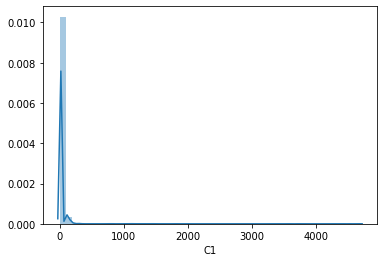

In [63]:
sns.distplot(newdf.C1.dropna())
plt.show()

In [59]:
newdf.isnull().mean(axis=0)

isFraud           0.000000
TransactionDT     0.000000
TransactionAmt    0.000000
ProductCD         0.000000
card1             0.000000
card2             0.015127
card3             0.002650
card4             0.002670
card5             0.007212
card6             0.002660
addr1             0.111264
addr2             0.111264
P_emaildomain     0.159949
C1                0.000000
C2                0.000000
C3                0.000000
C4                0.000000
C5                0.000000
C6                0.000000
C7                0.000000
C8                0.000000
C9                0.000000
C10               0.000000
C11               0.000000
C12               0.000000
C13               0.000000
C14               0.000000
D1                0.002149
D4                0.286047
D10               0.128733
                    ...   
V292              0.000020
V293              0.000020
V294              0.000020
V295              0.000020
V296              0.002149
V297              0.000020
V

In [78]:
#fill NaN by most_frequency (have to adapt with categorical columns)
newdf2 = pd.get_dummies(newdf)
def Most_freq(targetdf, cols):
    df = targetdf.copy()
    for col in cols:
        if(df[col].isnull().mean(axis=0) > 0):
            print(col)
            most_frequency = df[col].value_counts(dropna = True).idxmax()
            print(most_frequency)
            df = df[col].fillna(most_frequency, inplace = True)
    return df

newdf3 = Most_freq(newdf2, newdf2.columns)
newdf3.isnull().mean(axis=0)

card2
321.0


TypeError: 'NoneType' object is not subscriptable

In [72]:
most_frequency = newdf2['TransactionDT'].value_counts(dropna = True).idxmax()
print(most_frequency)

9474817


In [ ]:
print(frauddf.mean())

In [ ]:
corr_with_Fraud = train.corrwith(train['isFraud'])
for d in corr_with_Fraud:
    if(d > 0.01):
        print((corr_with_Fraud==d).argmax(), d)


In [5]:
corr_with_Fraud = train.corrwith(train['isFraud'])
print(corr_with_Fraud)

isFraud           1.000000
TransactionDT     0.013103
TransactionAmt    0.011320
card1            -0.013640
card2             0.003388
card3             0.154151
card5            -0.033580
addr1             0.005596
addr2            -0.030387
dist1             0.021522
dist2            -0.019054
C1                0.030570
C2                0.037229
C3               -0.006833
C4                0.030382
C5               -0.030754
C6                0.020909
C7                0.028160
C8                0.032139
C9               -0.031703
C10               0.028396
C11               0.027484
C12               0.031905
C13              -0.011146
C14               0.007921
D1               -0.067193
D2               -0.083583
D3               -0.046271
D4               -0.067216
D5               -0.064638
                    ...   
V333             -0.024134
V334             -0.000451
V335             -0.005456
V336             -0.002402
V337             -0.005702
V338             -0.019356
V

In [16]:
train.columns

Index(['isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1',
       'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=433)

In [ ]:
msno.heatmap(train.iloc[:, :5])

In [ ]:
msno.matrix(df=train.iloc[:, 61:80], figsize=(20, 20), color=(0.2, 0.3, 0.8))

In [ ]:
###Fraud ratio pie chart
f, ax = plt.subplots(1, 2, figsize=(18, 10))

train['isFraud'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - isFraud')
ax[0].set_ylabel('')
sns.countplot('isFraud', data=train, ax=ax[1])
ax[1].set_title('Count plot - isFraud')

plt.show()

In [19]:
train['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,DeviceInfo_verykoolS5019,DeviceInfo_verykoolS5524,DeviceInfo_verykoolS5525,DeviceInfo_verykoolS5530 Build/LMY47I,DeviceInfo_verykools4009,DeviceInfo_verykools5004,DeviceInfo_verykools5034,DeviceInfo_verykools5035,DeviceInfo_vivo,DeviceInfo_xs-Z47b7VqTMxs
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,...,0,0,0,0,0,0,0,0,0,0
2987001,0,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2987002,0,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,...,0,0,0,0,0,0,0,0,0,0
2987003,0,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2987004,0,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,NaN,...,0,0,0,0,0,0,0,0,0,0


In [30]:
print(train2.columns)

Index(['isFraud', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3',
       'card5', 'addr1', 'addr2', 'dist1',
       ...
       'DeviceInfo_verykoolS5019', 'DeviceInfo_verykoolS5524',
       'DeviceInfo_verykoolS5525', 'DeviceInfo_verykoolS5530 Build/LMY47I',
       'DeviceInfo_verykools4009', 'DeviceInfo_verykools5004',
       'DeviceInfo_verykools5034', 'DeviceInfo_verykools5035',
       'DeviceInfo_vivo', 'DeviceInfo_xs-Z47b7VqTMxs'],
      dtype='object', length=2834)


In [52]:
#train_tr['isFraud'].count()

590540

In [ ]:
#without preprocessing

# del train
# del train_tr
# del train_id

# train = train.drop(columns=['dist2','R_emaildomain','D2','D3','D4','D5',
#                              'D7','D8','D9','D12','D13','D14'
#                             ])
# train = train.drop(columns=['V1','V2'])
train = train.loc[:,['isFraud','TransactionDT','TransactionAmt','ProductCD','card1',
                     'card2','card3','C1','C2','C3','C4',
                     'V12'
                    ]]
#print(train)
train2 = pd.get_dummies(train)
train2=train2.dropna(axis=0)
#train2.isnull().sum(axis=0)

#y= pd.get_dummies(train2.isFraud)
y =train2.isFraud
X = train2.drop(columns=['isFraud'])

#headerX = train2.drop(columns=['isFraud']).columns

In [12]:
X2= np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.3,shuffle = False )
print(X2.shape)
print(y.shape)


(505914, 15)
(505914,)


In [ ]:
print(X_train)

In [22]:
print(y_train[:])

2
[0 0 0 ... 0 0 0]


In [17]:
glm = LogisticRegression()
glm.fit(X_train, y_train[:])
y_pred = glm.predict(X_test)
acc = np.mean(y_test[:] == y_pred )
print("SKLEARN Logistic Regression Accuracy = {:3.3f}".format(acc))

SKLEARN Logistic Regression Accuracy = 0.968
